**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation.

In [1]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.1 MB/s eta 0:00:00


In [2]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 92.0MB/s]


In [3]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:

apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$

We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.




When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:

1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)

3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.


The following function performs the above-mentioned steps for our IMDB dataset.



In [4]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len:
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

"fit_on_texts" iterates through the words in the message and assigns each with an integer corresponding to the frequency. The result is a dictionary where each key,value refer to a word and its corresponding value based on its frequency.


**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

Given a list of words, "text_to_sequences" outputs the a list of word indices corresponding to their index in the frequency dictionary/tokenizer's vocabulary.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

Given a list of sequences "pad_sequences" adds padding to the start of the sentence in order to ensure all sequences in the output list are equal in length, which is the length of the longest sequence, or can be specified using "maxlen". This is needed because the input data to models must have a consistent shape.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [5]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [6]:
print(messages_train[0])

[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586    9   36    1
  454 

This input is an array of dimension (200, ) where each integer corresponds to some word in the vocabulary. Other input samples (not shown in above code) have been padded with 0's to keep the shape, and we note that the max_len and max_vocab are 200 and 2000, consistent with what is shown in this training example (no integer in the array exceeds 2000). This is what we expect.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry.

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows.

In [7]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

__init__ takes in 2 integers for defining the dimensions of the embedding matrix. It has the shape (size, latent). __call__ takes in our sentence (in the form of input indices) outputs the corresponding embeddings, using the embedding matrix for indexing.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

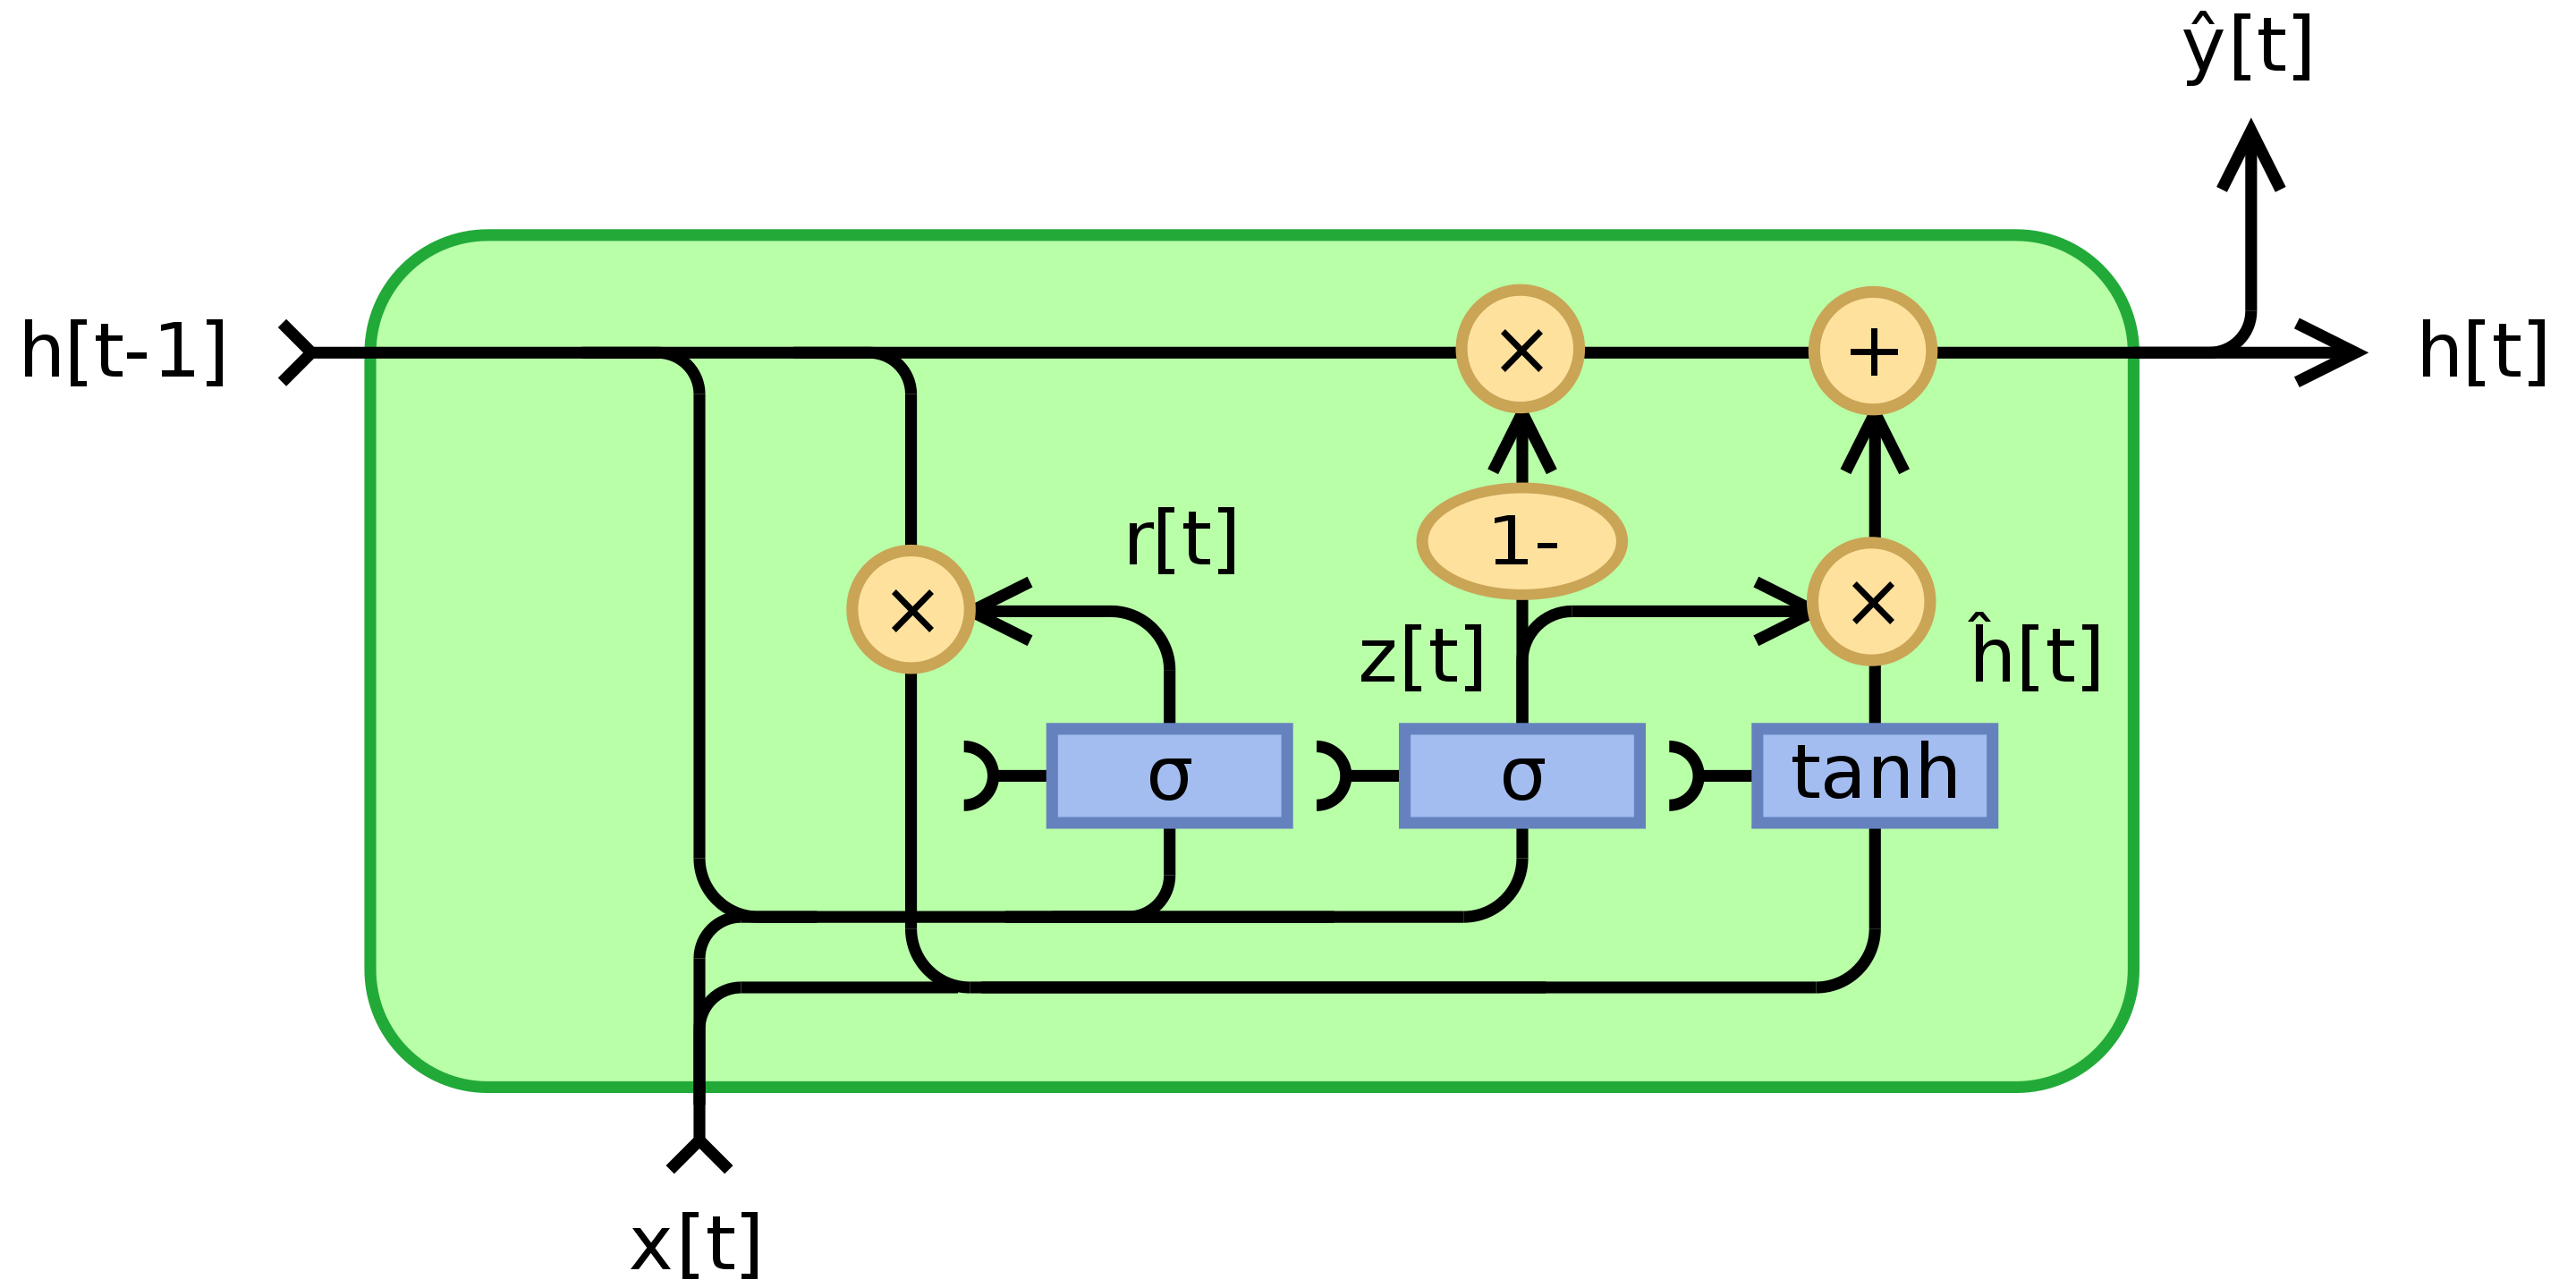

To learn more about GRU, please watch these short videos:

https://www.youtube.com/watch?v=8HyCNIVRbSU

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function.

In [8]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            # fill this in
            output_gate = objax.functional.tanh(jn.dot(x, self.output_w.value) + jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

The lax.scan function applies a given function repeatedly, in a loop, taking the previous state of an input and produces a new state and output. This can be seen in an example using the fib function to compute fibonnaci numbers. lax.scan takes in a function (fibonacci function), an initial value (0 and 1 to start the sequence), and an array (sequence from 0 to 9) which will be iterated through. This is useful to simplify looping functions and speed up their computation.

In [9]:
#define a fib function for scan
def fib(prev_state, x):
    curr, prev = prev_state
    new_fib = curr + prev
    return (new_fib, curr), new_fib
# call lax.scan
out, fib_sequence = lax.scan(fib, (jn.array(1), jn.array(0)), jn.arange(10))

print("output:", out)
print("fib sequence:", fib_sequence)

output: (Array(89, dtype=int32, weak_type=True), Array(55, dtype=int32, weak_type=True))
fib sequence: [ 1  2  3  5  8 13 21 34 55 89]


# The classifier

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [10]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    #matrix size: max_len x embedding_size
  Embed(max_vocab, embedding_size),
    #GRU cell, output is num_hidden_units_GRU
  GRU(embedding_size, num_hidden_units_GRU),
  #FC layer
  objax.nn.Linear(num_hidden_units_GRU,  num_hidden_units),
  objax.functional.relu,
    #2 o/p
  objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [11]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU.

Please refer to Q9 diagram on crowdmark.

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [12]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [13]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())

The next function is a helper for computing the accuracy.

In [14]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [15]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [16]:
# you code for the training loop should start here
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(messages_train))
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid))
      np.random.shuffle(val_indices)
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  #test accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

Epoch 0001  Training Loss 172.57 Validation Loss 171.05 Training Accuracy 55.46 Validation Accuracy 57.44
Epoch 0002  Training Loss 168.11 Validation Loss 165.11 Training Accuracy 60.59 Validation Accuracy 58.30
Epoch 0003  Training Loss 162.18 Validation Loss 159.54 Training Accuracy 63.40 Validation Accuracy 62.48
Epoch 0004  Training Loss 154.69 Validation Loss 146.70 Training Accuracy 66.62 Validation Accuracy 69.14
Epoch 0005  Training Loss 147.42 Validation Loss 161.03 Training Accuracy 69.45 Validation Accuracy 62.48
Epoch 0006  Training Loss 143.66 Validation Loss 139.13 Training Accuracy 70.95 Validation Accuracy 71.18
Epoch 0007  Training Loss 141.11 Validation Loss 127.11 Training Accuracy 72.54 Validation Accuracy 74.94
Epoch 0008  Training Loss 137.29 Validation Loss 132.69 Training Accuracy 73.52 Validation Accuracy 74.52
Epoch 0009  Training Loss 134.54 Validation Loss 143.22 Training Accuracy 74.57 Validation Accuracy 71.54
Epoch 0010  Training Loss 135.35 Validation Lo

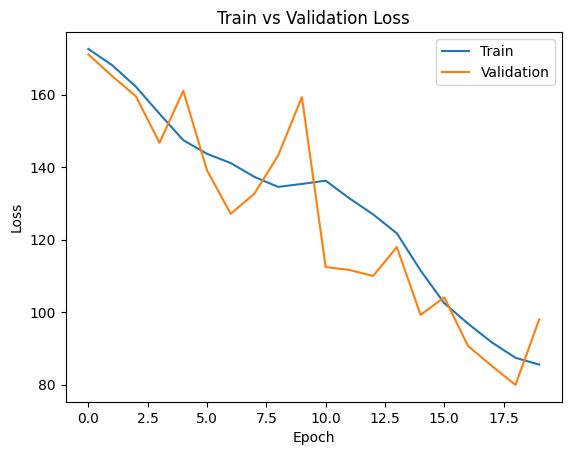

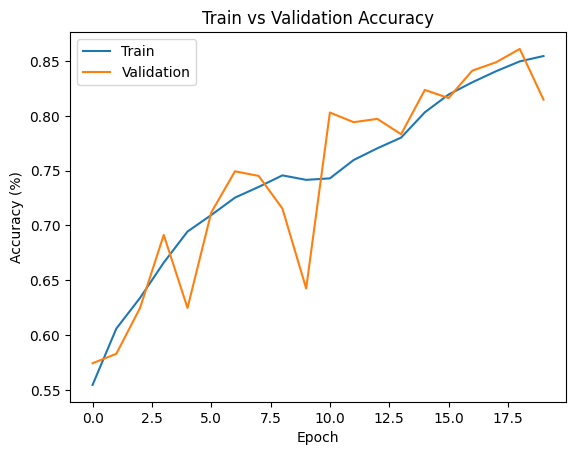

Test Accuracy: 82.36%


In [17]:
train()

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

The generalization gap between test and training is 85.45 - 82.36 = 3.09. That is, the accuracy for the training data is 3.09 higher than on test set on the 20th epoch.

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [18]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [19]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [20]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [21]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [22]:
# you code for the training loop should start here
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(messages_train))
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid))
      np.random.shuffle(val_indices)
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  #TODO print test accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")


Epoch 0001  Training Loss 118.35 Validation Loss 78.47 Training Accuracy 77.62 Validation Accuracy 86.76
Epoch 0002  Training Loss 74.10 Validation Loss 74.52 Training Accuracy 88.43 Validation Accuracy 87.26
Epoch 0003  Training Loss 67.64 Validation Loss 69.68 Training Accuracy 89.49 Validation Accuracy 87.96
Epoch 0004  Training Loss 63.27 Validation Loss 69.30 Training Accuracy 90.26 Validation Accuracy 87.90
Epoch 0005  Training Loss 60.30 Validation Loss 69.61 Training Accuracy 90.78 Validation Accuracy 88.24
Epoch 0006  Training Loss 58.13 Validation Loss 70.03 Training Accuracy 91.21 Validation Accuracy 88.12
Epoch 0007  Training Loss 54.55 Validation Loss 75.40 Training Accuracy 91.78 Validation Accuracy 87.02
Epoch 0008  Training Loss 52.18 Validation Loss 74.75 Training Accuracy 92.17 Validation Accuracy 87.86
Epoch 0009  Training Loss 48.67 Validation Loss 73.91 Training Accuracy 92.88 Validation Accuracy 87.42
Epoch 0010  Training Loss 46.06 Validation Loss 80.10 Training 

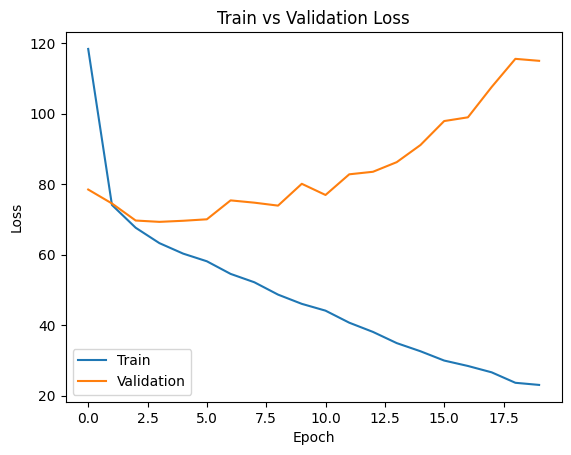

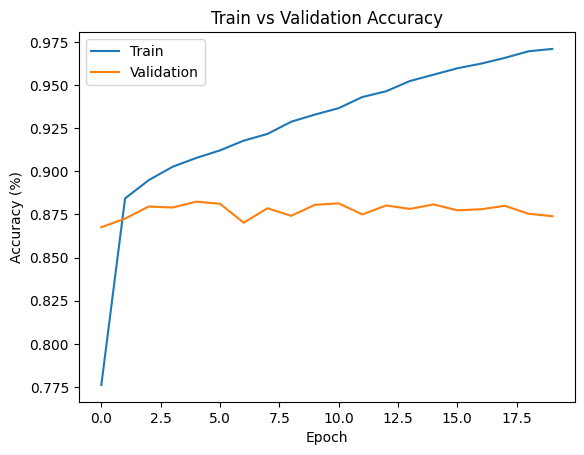

Test Accuracy: 86.9%


In [23]:
train()

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

The generalization gap here is 97.09 - 86.9% = 10.19, which represents the difference between the training accuracy on the 20th epoch and the testing accuracy.

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

The Adam optimizer is an alogorithm that uses both the past gradients and the squares of the past gradients to update weights, and uses a bias correction on the average of the two. It differs from SGD in that it has an adaptable learning rate whereas SGD has a fixed learning rate, and it also uses an average of (namely, an exponential decaying average) past gradients and squared gradients whereas SGD relies on only the regular gradient. Due to Adam's adaptive learning rate, it can typically enable faster convergence.

# Early Stopping

**Questions 16** [3 points]:
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [24]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [25]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [26]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [27]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [28]:
# you code for the training loop should start here
def train(EPOCHS = num_epochs, BATCH =batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []
  loss_sequence = 0
  loss_increase = False

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(messages_train))
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid))
      np.random.shuffle(val_indices)
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])
      #early stopping
      if (avg_val_loss_epoch[len(avg_val_loss_epoch)-1] > avg_val_loss_epoch[len(avg_val_loss_epoch)-2]):
        if loss_increase:
          loss_seq += 1
        else:
          loss_increase = True
          loss_seq = 1

        if (loss_seq >= max_patience_window):
          print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
          print("Validation Error Increased. BREAK!")
          break
      else:
        loss_increase = False
      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

  # get test accuracy
  print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 117.20 Validation Loss 76.69 Training Accuracy 76.83 Validation Accuracy 86.82
Epoch 0002  Training Loss 74.45 Validation Loss 72.39 Training Accuracy 88.36 Validation Accuracy 87.66
Epoch 0003  Training Loss 69.27 Validation Loss 70.22 Training Accuracy 89.17 Validation Accuracy 87.94
Epoch 0004  Training Loss 66.63 Validation Loss 70.05 Training Accuracy 89.48 Validation Accuracy 88.00
Epoch 0005  Training Loss 63.90 Validation Loss 71.83 Training Accuracy 90.00 Validation Accuracy 87.38
Epoch 0006  Training Loss 61.38 Validation Loss 68.78 Training Accuracy 90.41 Validation Accuracy 88.36
Epoch 0007  Training Loss 57.20 Validation Loss 68.40 Training Accuracy 91.19 Validation Accuracy 88.50
Epoch 0008  Training Loss 55.35 Validation Loss 69.37 Training Accuracy 91.53 Validation Accuracy 88.28
Epoch 0009  Training Loss 51.99 Validation Loss 69.25 Training Accuracy 91.98 Validation Accuracy 88.44
Epoch 0010  Training Loss 49.16 Validation Loss 69.26 Training 

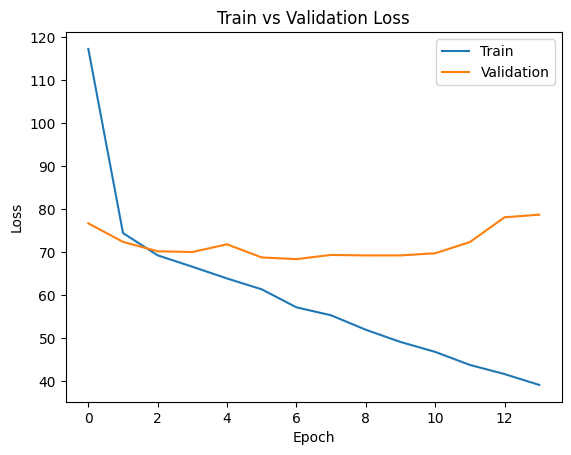

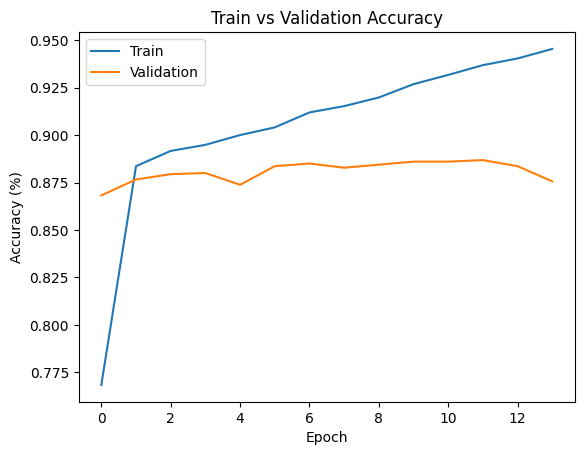

In [29]:
train()

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The validation and test accuracy of this model is 88.68% and 87.8% respectively. This is the best model in terms of validation and test performance.

# Model cards

Our invited guest lecturer Deborah Raji presented her research about model cards as part of her lecture. In this last question, you are encouraged to read about model cards in [the publication by Mitchell et al.](https://arxiv.org/abs/1810.03993) co-authored by Deborah Raji.

**Question 18** [3 points] Write a model card for the model you developed in this assignment. Your card should at least contain 3 sections described in Figure 1 of the [paper by Mitchell et al.](https://arxiv.org/abs/1810.03993): Model Details, Intended Use, Metrics.

> you should type your model card here

1. Model Details
 - Developer: Kai Li
 - Model Date: released 12/06/23
 - Model Version: 1.0
 - Model Type: DNN
 - Model architecture: Sequential model containing 4 layers. Embedding layer -> GRU layer -> Linear layer -> Output layer.
 - Model Hyperparameters: trained on 20 epochs—with early stopping at epoch 14, maximum patience window of 5 epochs, batch size of 250, initial learning rate of 1e-3, optimizer: Adam
 - Libraries and frameworks: Tensorflow, Sklearn, Objax
 - For training dataset refer here (IMDB dataset with sentiment labels): https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
 - For more sentiment analysis using GRU NN refer to the following: Sachin, Sharat, et al. "Sentiment analysis using gated recurrent neural networks." SN Computer Science 1 (2020): 1-13.
 2. Intended Use
 - Primary use case: To validate the performance of a baseline gated recurrent neural network on a sentiment analysis task
 - Primary intended users: students, teachers, machine learning engineers, anyone interested in building/using this model
 - Out of Scope use cases: Not to be confused with a generative language model, this model simply predicts a sentiment [positive, negative] based on a text input of a review. Moreover due to the model's limited training data on only IMDB reviews, it may fail to generalize for categories outside of movies, shows, etc.
 3. Metrics
 - Model Performance Measures: The loss function used is cross entropy loss which is well suited for classification tasks. From this we derive our model accuracy. Note that one may experiment with other loss functions; this model is only a baseline.
 - Decision threshold: There is no explicit decision threshold for this task, rather the final decision is determined by which class in the output vector has the largest value (via argmax)
 - Approaches to Uncertainty and Variability: One way the model addresses variability is by observing the generalization gap during training, acknowledging the  differences that exist between our training and testing data. To ensure reproducibility, a seed is set to ensure the same random values are obtained each time (objax.random.DEFAULT_GENERATOR.seed(42) and
np.random.seed(42))
